In [1]:
# Preambles
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# The Sheet resistance extraction theory can be found here:
# http://tuttle.merc.iastate.edu/ee432/topics/doping/resistance.pdf
# https://www2.pvlighthouse.com.au/calculators/sheet%20resistance%20calculator/sheet%20resistance%20calculator.aspx
# https://www.chu.berkeley.edu/wp-content/uploads/2020/01/Chenming-Hu_ch2-2.pdf

# Some key constants
q = 1.602176634e-19 # charge of an electron (C)
n_i = 1.45e10 # Intrinsic carrier concentration of Si (/cm3)
elec_mass = 1.098e+27 # grams
# mean free time (sec)
tau_c = 2.81e-9

substr_doping = 3e12 # Substrate doping concentration (/cm3)

# Some constraints
sigma_max = 0.5
sigma_min = 0.2

# Data Storage
Data_Store = {}

# Gain Layer Files
# FBK gain layer
gain_layer_FBK = 'doping_pFBK.dat'
# BNL gain layer
gain_layer_BNL = 'doping_p1.dat'
# BNL gain layer deep
gain_layer_BNLdeep = 'doping_p1_deep.dat'


# BNL_n+ layer
nPlus_layer_BNL = 'doping_n1.dat'

# Degenerative Doping concentration
Degen_doping = 1e22


In [2]:
'''
    Defining functions to extract surface resistance.

'''

# Provides interpolated data set (we need to unify physical axis size)
def interp_profiles(depth_axes=[[],[]], dopant_conc=[[],[]]):
    n_dop_axis = np.array( depth_axes[0] )
    p_dop_axis = np.array( depth_axes[1] )
    n_dop = np.array( np.abs(dopant_conc[0]) )
    p_dop = np.array( np.abs(dopant_conc[1]) )
    
    axis_min = min([np.amin(n_dop_axis), np.amin(p_dop_axis)])
    axis_max = max([np.amax(n_dop_axis), np.amax(p_dop_axis)])
    
    # This code generates too many points... Let's just give in a few given points...
    #axis_diff = np.min( np.concatenate( ( np.diff(n_dop_axis), np.diff(p_dop_axis) ) ) )
    #y_axis = np.linspace( axis_min, axis_max, int((axis_max-axis_min)/axis_diff) )

    y_axis = np.sort( np.concatenate( (n_dop_axis, p_dop_axis) ) )
    
    n_dop_interp = np.interp( y_axis, n_dop_axis, n_dop )
    p_dop_interp = np.interp( y_axis, p_dop_axis, p_dop )
    
    return [y_axis, n_dop_interp, p_dop_interp]

# Returns mobility of majority carrier in cm/Vs -> Masetti Model (Numbers adopted from Sentaurus Manual)
def MobilityMajor(depth_axes=[[],[]], dopant_conc=[[],[]], model='normal'):

    x_n = depth_axes[0]
    x_p = depth_axes[1]
    dop_n = dopant_conc[0]
    dop_p = dopant_conc[1]

    # sanitizing dopant concentration.
    dop_n_san = []
    for n in dop_n:
        if n > n_i:
            dop_n_san.append(n)
        else:
            dop_n_san.append(n_i)
    dop_n = np.array(dop_n_san)
    
    dop_p_san = []
    for p in dop_p:
        if p > n_i:
            dop_p_san.append(p)
        else:
            dop_p_san.append(n_i)
    dop_p = np.array(dop_p_san)
    
    if model == 'normal':

        nplus_dop_p = n_i**2 / dop_n
        pplus_dop_n = n_i**2 / dop_p
        
        # mu_p_nplus = 50 + 420 / ( 1 + ( (nplus_dop_p+dop_n)/1.6e17 )**0.7 )
        mu_n_nplus = 92 + 1318 / ( 1 + ( (nplus_dop_p+dop_n)/1e17 )**0.85 )
        
        mu_p_pplus = 50 + 420 / ( 1 + ( (pplus_dop_n+dop_p)/1.6e17 )**0.7 )
        # mu_n_pplus = 92 + 1318 / ( 1 + ( (pplus_dop_n+dop_p)/1e17 )**0.85 )
        
        mu_major = []
        for ind, [dn, dp] in enumerate( zip(dop_n, dop_p) ):
            if dn > dp:
                mu_major.append(mu_n_nplus[ind])
            else:
                mu_major.append(mu_p_pplus[ind])
                
        
        return np.array(mu_major)
        
    
    if model == 'klassen':
        mu_const_n = 1360.0
        mu_const_p = 480.0
        mu_min_1_n = 52.2
        mu_min_1_p = 44.9
        mu_min_2_n = 52.2
        mu_min_2_p = 0.0
        mu_1_n = 43.4
        mu_1_p = 29.0
        Pc_n = 0.0
        Pc_p = 9.23e16
        Cr_n = 9.68e16
        Cr_p = 2.23e17
        Cs_n = 3.43e20
        Cs_p = 6.10e20
        alpha_n = 0.68
        alpha_p = 0.719
        beta_n = 2.0
        beta_p = 2.0

        mu_dop_n = mu_min_1_n*np.exp(-Pc_n/(dop_p+dop_n)) + \
                (mu_const_n-mu_min_2_n)/( 1+((dop_p+dop_n)/Cr_n)**alpha_n ) - \
                mu_1_n/( 1+(Cs_n/(dop_p+dop_n))**beta_n )

        mu_dop_p = mu_min_1_p*np.exp(-Pc_p/(dop_p+dop_n)) + \
            (mu_const_p-mu_min_2_p)/( 1+((dop_p+dop_n)/Cr_p)**alpha_p ) - \
            mu_1_p/( 1+(Cs_p/(dop_p+dop_n))**beta_p )

        d_len = len(dop_n)
        mu_dop = []
        for i in range(d_len):
            if dop_n[i] >= dop_p[i]:
                mu_dop.append(mu_dop_n[i])
            else:
                mu_dop.append(mu_dop_p[i])

        return np.array(mu_dop)

# In our case, junction depth isn't just Doping profile - background.
# We have yet another doping profile due to 
def JunctionDepth(depth_axes=[[],[]], dopant_conc=[[],[]], verbose=False):
    y, n_dop, p_dop = interp_profiles(depth_axes, dopant_conc)
    dop_diff = np.array(n_dop)-np.array(p_dop)
    if dop_diff[0] < 0.0:
        dop_diff = np.array(dop_diff)*(-1.0)
    
    i = 0
    while dop_diff[i] > 0:
        i += 1
    
        if i == len(dop_diff):
            raise ("Junction Depth cannot be found!!")
            return 0.0

    if verbose:
        print("Junciton Depth confimed around y={} um and y={} um".format(y[i-1]*1e4,y[i]*1e4))
    
    # We need to extract zero crossing between...
    # (y[i-1], dop_diff[i-1]) and (y[i], dop_diff[i])
    #
    # Using y-y1 = m(x-x1) ...
    # -y1/m+x1 = x when y=0
    m = (dop_diff[i]-dop_diff[i-1])/(y[i]-y[i-1])
    if m == 0.0:
        print("Oops, we need some slope!")
        return 0.0
    x_j = -dop_diff[i-1]/m + y[i-1]
    
    return x_j

def IntegrateMobilityDensity(depth_axes=[[],[]], dopant_conc=[[],[]]):
    y_j = JunctionDepth(depth_axes, dopant_conc)
    y_orig, n_dop, p_dop = interp_profiles(depth_axes, dopant_conc)
    N_z = np.abs(n_dop-p_dop)
    mu_dop = MobilityMajor([y_orig, y_orig], [n_dop, p_dop])
    
    y_integ = []
    N_z_integ = []
    mu_dop_integ = []
    
    i = 0
    while y_orig[i] < y_j:
        y_integ.append(y_orig[i])
        N_z_integ.append(N_z[i])
        mu_dop_integ.append(mu_dop[i])
        i += 1
    
    return np.trapz( np.array(N_z_integ)*np.array(mu_dop_integ), np.array(y_integ) )

def SheetResistance(depth_axes=[[],[]], dopant_conc=[[],[]]):
    # Converting um to cm
    depth_axes[0] = np.array(depth_axes[0])*1e-4
    depth_axes[1] = np.array(depth_axes[1])*1e-4
    dopant_conc = [ np.array(dopant_conc[0]), np.array(dopant_conc[1]) ]
    sig_sq = 1.0/( q*IntegrateMobilityDensity(depth_axes, dopant_conc) )
    return sig_sq
    
'''
    Reading in data from dat file or else
'''
def read_dat(dat_file):
    x = []
    y = []
    with open(dat_file, 'r') as fp:
        flines = fp.readlines()
        for l in flines:
            line = l.strip()
            if not line:
                continue
            if line[0] == '\"' and line[-1] == '\"':
                continue
            if line[0] == '#':
                continue
            if line.strip() == '':
                continue
            
            l_elements = line.split()
            x.append( float(l_elements[0]) )
            y.append( float(l_elements[1]) )
        
    return [x, y]


In [3]:
'''
    Let's make some gaussian profile data -> Warning! returns um data, not cm!
    
'''
def GaussData(PeakPos=0.0, PeakConc=2.5e18, StdDev=0.135, x_max=10.0):
    x = np.linspace(0, x_max, int( (x_max - PeakPos)/0.00001 ))
    gauss = PeakConc*np.exp( -(((x-PeakPos)/StdDev)**2.0)/2.0 )
    return [x, gauss]

'''
    Let's rather make an Erfc data!!
    
'''
# First, defining Erfc
def erfc(x):
    # Trying out Scipy first
    try:
        from scipy import special
        return special.erfc(x)
    # if it fails, using python's built-in erfc from math
    # --> Requires 2.7 or higher.
    except ImportError:
        from math import erfc
        return erfc(x)
        
def ErfcData(PeakPos=0.0, PeakConc=2.5e18, StdDev=0.135, x_max=10.0):
    x = np.linspace(0, x_max, int( (x_max - PeakPos)/0.00001) )
    erfc_data = [ PeakConc*erfc(  (_x-PeakPos)/(2*np.sqrt(StdDev))  ) for _x in x ]
    return [x, erfc_data]


In [4]:
'''
Let's test with a simple gaussian - FBK Gain Layer
'''

gain_layer = gain_layer_FBK
p_dop_y, p_dop = read_dat(gain_layer)

# n_dop_y, n_dop = read_dat('1kOhm.dat')
 
# p_dop_y, p_dop = np.linspace(0, 50, 10), np.array([substr_doping for _ in range(10)])
n_dop_y, n_dop = GaussData(0.0, 1.05e19, 0.045)
'''
1kOhm surface has profile of
x.characteristic= 0.0 y.characteristic=0.135
Peak doping (1kOhm)=2.5E18
--> Obtained by Silvaco Simulator
'''

plot_it = False
if plot_it:
    plt.figure()
    plt.plot(p_dop_y, p_dop, label='pDoping')
    plt.plot(n_dop_y, n_dop, label='nDoping')
    plt.xlabel('Depth (um)')
    plt.ylabel('Doping Concentration (/cm3)')

depth_axes = [n_dop_y, p_dop_y]
dopant_conc = [n_dop, p_dop]

x_j = JunctionDepth(depth_axes, dopant_conc); print("Junction depth: {} um".format(x_j))
Rsh = SheetResistance(depth_axes, dopant_conc); print("Sheet Resistance: {} Ohm/cm2".format(Rsh))

Junction depth: 0.22126909501099093 um
Sheet Resistance: 756.6902042784421 Ohm/cm2


In [6]:
# Returning the gain layer back to BNL
gain_layer = gain_layer_BNL

In [7]:
# Reading in BNL n+ data for reference
n_dop_y, n_dop = read_dat(nPlus_layer_BNL)
Data_Store = {}
Data_Store[('BNL',)] = [n_dop_y, n_dop]

In [8]:
# Plot All Gauss
def PlotAll():
    PlotSheetR(list(Data_Store.keys()))
    
def PlotSheetR(list_sheet_r, savef_name=''):
    plt.figure()
    p_dop_y, p_dop = read_dat(gain_layer)

    max_y = []
    lbl_list = []
    for rsh in list_sheet_r:
        
        if 'BNL' in rsh and len(rsh) == 1:
            x = Data_Store[rsh][0]
            y = Data_Store[rsh][1]
            lbl = 'BNL SIMS Data'
            lbl_list.append(lbl)
            plt.plot(x, y, label=lbl)
            max_y.append(max(y))
            continue
        
        if rsh[-1] == 'gauss':
            x, y = GaussData(Data_Store[rsh][0], Data_Store[rsh][1], Data_Store[rsh][2])
        elif rsh[-1] == 'erfc':
            x, y = ErfcData(Data_Store[rsh][0], Data_Store[rsh][1], Data_Store[rsh][2])

        max_y.append(max(y))
        lbl = f'{rsh[0]} Ohm, StdDev: {Data_Store[rsh][2] :.2f} um, Model: {rsh[3]}'
        lbl_list.append(lbl)
        plt.plot( x, y, label=lbl )

    plt.plot( p_dop_y, p_dop, label='Gain Layer' )
    plt.xlim([0, max(p_dop_y)*0.75])
    plt.ylim([substr_doping*0.8, max(max_y)*1.2])
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Depth (um)')
    plt.ylabel('Net Doping Concentration (/cm3)')
    
    if savef_name:
        plt.savefig(savef_name+'.jpg', bbox_inches='tight')

In [9]:
'''
Let's figure out a Correct Gaussian for a given sheet resistance value.

'''
def write_sdevice_code(peak_pos, peak_conc, std_dev, mode):
    
    if mode == 'gauss':
        analytic_model_string = ' \"Gauss\"'
    elif mode == 'erfc':
        analytic_model_string = ' \"Erf\"'
    
    out_str = '\n'.join([
        f"(sdedr:define-gaussian-profile \"LGADnPlus\"",
        "  \"PhosphorusActiveConcentration\"",
        f"  \"PeakPos\" {peak_pos} \"PeakVal\" {peak_conc} \"StdDev\" {std_dev}",
        "  {} \"Factor\" 1.0)".format(analytic_model_string), 
        "(sdedr:define-analytical-profile-placement \"Impl.nPlus\"",
        "  \"LGADnPlus\" \"RefWin.LGADCn\"",
        "  \"Positive\" \"NoReplace\" \"Eval\")" ])
    print(out_str)

epsilon = 1e-4
def is_close(val, target_val):
    if np.abs(val-target_val) <= epsilon:
        return True
    else:
        return False

def TrackDoping(SheetR, given_depth_axis, given_profile, given_profile_type='p',
              std_dev_max=sigma_max,
              std_dev_min=sigma_min,
              peak_conc_max=Degen_doping, gain_layer=gain_layer_BNL,
              max_iteration='',
              dynamic_ratio=True,
              fix_peak_pos=True,
              analytic_model='gauss',
              debug=False):
    
    given_condition = (SheetR, std_dev_max, std_dev_min, analytic_model)
    
    incr_ratio = 1.1
    decr_ratio = 2.6
    
    peak_pos_init = 0.0
    peak_pos_delta = incr_ratio
    
    peak_conc_init = 1e15
    peak_conc_delta = incr_ratio
    
    std_dev_init = (std_dev_max+std_dev_min)/2.0
    std_dev_delta = incr_ratio

    iteration = 1
    delta = 100000000000.0000
    peak_pos = peak_pos_init
    peak_conc = peak_conc_init
    std_dev = std_dev_init
    if peak_pos_init == 0.0:
        peak_pos_incr = 0.1
    else:
        peak_pos_incr = peak_pos_init/10.0
    peak_conc_incr = peak_conc_init/3.0
    std_dev_incr = std_dev_init/10.0
    
    peak_pos_incr_init = peak_pos_incr
    peak_conc_incr_init = peak_conc_incr
    std_dev_incr_init = std_dev_incr
    
    print("** Starting Iteration **")
    print("# Model: {}".format(analytic_model))
    print(" #\tRsheet\t\tDelta\t\tPeak Pos\tPeak Conc\tStd Dev ")
    print("-----------------------------------------------------------------------------------------")
    
    def getRsh(peak_pos, peak_conc, std_dev, mode='gauss'):
        if mode == 'gauss':
            prof_x, prof_y = GaussData(peak_pos, peak_conc, std_dev)
        elif mode == 'erfc':
            prof_x, prof_y = ErfcData(peak_pos, peak_conc, std_dev)
        if given_profile_type == 'p':
            depth_axis = [prof_x, given_depth_axis]
            profile = [prof_y, given_profile]
        else:
            depth_axis = [given_depth_axis, prof_x]
            profile = [given_profile, prof_y]
        return SheetResistance(depth_axis, profile)
    
    while np.abs(delta) > epsilon*SheetR:

        delta_prev = delta
        Rsh_prev = getRsh(peak_pos, peak_conc, std_dev, analytic_model)
        delta_list = {}
        incr_delta_list = {}
        
        # Checking peak_pos
        if not fix_peak_pos:
            new_peak_pos = peak_pos+peak_pos_incr
            if new_peak_pos < 0.0:
                new_peak_pos = peak_pos
            Rsh_peak_pos = getRsh(new_peak_pos, peak_conc, std_dev, analytic_model)
            delta_peak_pos = Rsh_peak_pos - SheetR
            if delta_peak_pos > delta_prev:
                peak_pos_incr *= -1
            else:
                peak_pos_incr *= incr_ratio 
            delta_list[delta_peak_pos**2] = 'peak_pos'
            incr_delta_list['peak_pos_incr'] = peak_pos_incr
        
        # Checking PeakConc
        new_peak_conc = peak_conc+peak_conc_incr
        if new_peak_conc < n_i:
            new_peak_conc = n_i
        elif new_peak_conc >= peak_conc_max:
            new_peak_conc = peak_conc_max
        Rsh_peak_conc = getRsh(peak_pos, new_peak_conc, std_dev, analytic_model)
        delta_peak_conc = Rsh_peak_conc - SheetR

        if dynamic_ratio:
            adj_ratio = np.abs(delta_peak_conc)/SheetR
            if adj_ratio < 1.0:
                adj_ratio = 1.0
        else:
            adj_ratio = 1.0        
        
        if delta_peak_conc < 0.0:
            peak_conc_incr = -np.abs(peak_conc_incr/decr_ratio)*adj_ratio
        else:
            peak_conc_incr = np.abs(peak_conc_incr*incr_ratio)*adj_ratio
        delta_list[delta_peak_conc**2] = 'peak_conc'
        incr_delta_list['peak_conc_incr'] = peak_conc_incr
        
        # Chekcing StdDev
        new_std_dev = std_dev+std_dev_incr
        if new_std_dev < 0.01:
            new_std_dev = std_dev
        elif new_std_dev >= std_dev_max:
            new_std_dev = std_dev_max
        elif new_std_dev < std_dev_min:
            new_std_dev = std_dev_min
        Rsh_std_dev = getRsh(peak_pos, peak_conc, new_std_dev, analytic_model)
        delta_std_dev = Rsh_std_dev - SheetR
        if dynamic_ratio:
            adj_ratio = np.abs(delta_std_dev)/SheetR
            if adj_ratio < 1.0:
                adj_ratio = 1.0
        else:
            adj_ratio = 1.0
        if delta_std_dev < 0.0:
            std_dev_incr = -np.abs(std_dev_incr/decr_ratio)*adj_ratio
        else:
            std_dev_incr = np.abs(std_dev_incr*incr_ratio)*adj_ratio
        delta_list[delta_std_dev**2] = 'std_dev'
        incr_delta_list['std_dev_incr'] = std_dev_incr
        
        if new_std_dev == std_dev_max and new_peak_conc == peak_conc_max and fix_peak_pos:
            print('>> We cannot adjust more since Peak Concentration and Standard Devitaions are at the max criteria!!')
            break
        
        # Determing which way to go ...
        delta_keys = list( delta_list.keys() )
        if debug:
            print(delta_list)
            print(incr_delta_list)
        if len( set( delta_list ) ) == 1:
            Rsh = Rsh_peak_conc
            peak_conc = new_peak_conc

        else:
            direction_index = min(delta_keys) 
        
            if delta_list[direction_index] == 'peak_pos':
                Rsh = Rsh_peak_pos
                peak_pos = new_peak_pos

            elif delta_list[direction_index] == 'peak_conc':
                Rsh = Rsh_peak_conc
                peak_conc = new_peak_conc

            elif delta_list[direction_index] == 'std_dev':
                Rsh = Rsh_std_dev
                std_dev = new_std_dev
        
        delta = np.abs(SheetR - Rsh)
        
        print(" {:d}\t{:.4e}\t{:.4e}\t{:.4e}\t{:.4e}\t{:.4f}"\
              .format(iteration, Rsh, delta, peak_pos, peak_conc, std_dev) )
        iteration += 1
        
        if max_iteration:
            if iteration > max_iteration:
                raise ValueError("Iteration maximum limit!!")

    print("-----------------------------------------------------------------------------------------")
    print("********* Iteration met! *********")
    
    print("Peak Position: {} um".format(peak_pos))
    print("Peak Concentration: {} /cm3".format(peak_conc))
    print("Standard Deviation: {} um".format(std_dev))
    print("")

    fitted_doping_params = [peak_pos, peak_conc, std_dev, analytic_model]
    Data_Store[given_condition] = fitted_doping_params
    print("SDevice Code:")
    write_sdevice_code(peak_pos, peak_conc, std_dev, analytic_model)
          
    return fitted_doping_params


In [12]:
gain_layer = gain_layer_BNLdeep
p_dop_y, p_dop = read_dat(gain_layer)

In [13]:
TrackDoping(1600.0, p_dop_y, p_dop, std_dev_max=0.25, std_dev_min=0.2);

** Starting Iteration **
# Model: gauss
 #	Rsheet		Delta		Peak Pos	Peak Conc	Std Dev 
-----------------------------------------------------------------------------------------
 1	8.1919e+05	8.1759e+05	0.0000e+00	1.3333e+15	0.2250
 2	1.6931e+03	9.3102e+01	0.0000e+00	1.8870e+17	0.2250
 3	1.5238e+03	7.6198e+01	0.0000e+00	1.8870e+17	0.2500
 4	1.5238e+03	7.6198e+01	0.0000e+00	1.8870e+17	0.2500
 5	1.5238e+03	7.6198e+01	0.0000e+00	1.8870e+17	0.2500
 6	1.5238e+03	7.6198e+01	0.0000e+00	1.8870e+17	0.2500
 7	1.5238e+03	7.6198e+01	0.0000e+00	1.8870e+17	0.2500
 8	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 9	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 10	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 11	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 12	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 13	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 14	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 15	1.6030e+03	3.0079e+00	0.0000e+00	1.7451e+17	0.2500
 16	1.60

In [14]:
TrackDoping(400.0, p_dop_y, p_dop, std_dev_max=0.25, std_dev_min=0.2);

** Starting Iteration **
# Model: gauss
 #	Rsheet		Delta		Peak Pos	Peak Conc	Std Dev 
-----------------------------------------------------------------------------------------
 1	8.1919e+05	8.1879e+05	0.0000e+00	1.3333e+15	0.2250
 2	7.5819e+02	3.5819e+02	0.0000e+00	7.5189e+17	0.2250
 3	5.0630e+02	1.0630e+02	0.0000e+00	1.5775e+18	0.2250
 4	3.9105e+02	8.9545e+00	0.0000e+00	2.4857e+18	0.2250
 5	4.2682e+02	2.6823e+01	0.0000e+00	2.1364e+18	0.2250
 6	3.8787e+02	1.2131e+01	0.0000e+00	2.5206e+18	0.2250
 7	4.0177e+02	1.7660e+00	0.0000e+00	2.3728e+18	0.2250
 8	4.0177e+02	1.7660e+00	0.0000e+00	2.3728e+18	0.2250
 9	4.0803e+02	8.0286e+00	0.0000e+00	2.3103e+18	0.2250
 10	4.0115e+02	1.1529e+00	0.0000e+00	2.3791e+18	0.2250
 11	3.9391e+02	6.0858e+00	0.0000e+00	2.4547e+18	0.2250
 12	3.9666e+02	3.3404e+00	0.0000e+00	2.4256e+18	0.2250
 13	3.9773e+02	2.2717e+00	0.0000e+00	2.4144e+18	0.2250
 14	3.9814e+02	1.8588e+00	0.0000e+00	2.4101e+18	0.2250
 15	3.9830e+02	1.6997e+00	0.0000e+00	2.4085e+18	0.2250
 16	3.98

In [ ]:
gain_layer = gain_layer_BNL
p_dop_y, p_dop = read_dat(gain_layer)

In [12]:
TrackDoping(1600.0, p_dop_y, p_dop, std_dev_max=0.25, std_dev_min=0.2);

** Starting Iteration **
# Model: gauss
 #	Rsheet		Delta		Peak Pos	Peak Conc	Std Dev 
-----------------------------------------------------------------------------------------
 1	1.5473e+05	1.5313e+05	0.0000e+00	1.3333e+15	0.2250
 2	6.0829e+03	4.4829e+03	0.0000e+00	3.6425e+16	0.2250
 3	2.1280e+03	5.2804e+02	0.0000e+00	1.4458e+17	0.2250
 4	1.4509e+03	1.4912e+02	0.0000e+00	2.6355e+17	0.2250
 5	1.6316e+03	3.1582e+01	0.0000e+00	2.1779e+17	0.2250
 6	1.6316e+03	3.1582e+01	0.0000e+00	2.1779e+17	0.2250
 7	1.5023e+03	9.7680e+01	0.0000e+00	2.1779e+17	0.2500
 8	1.5023e+03	9.7680e+01	0.0000e+00	2.1779e+17	0.2500
 9	1.5391e+03	6.0922e+01	0.0000e+00	2.0960e+17	0.2500
 10	1.5539e+03	4.6086e+01	0.0000e+00	2.0645e+17	0.2500
 11	1.5597e+03	4.0271e+01	0.0000e+00	2.0524e+17	0.2500
 12	1.5620e+03	3.8017e+01	0.0000e+00	2.0477e+17	0.2500
 13	1.5629e+03	3.7148e+01	0.0000e+00	2.0459e+17	0.2500
 14	1.5632e+03	3.6814e+01	0.0000e+00	2.0452e+17	0.2500
 15	1.5633e+03	3.6685e+01	0.0000e+00	2.0450e+17	0.2500
 16	1.56

In [13]:
TrackDoping(1600.0, p_dop_y, p_dop, std_dev_max=0.05, analytic_model='erfc');

 #	Rsheet		Delta		Peak Pos	Peak Conc	Std Dev 
-----------------------------------------------------------------------------------------
 1	2.1285e+05	2.1125e+05	0.0000e+00	1.3333e+15	0.0309
 2	6.3663e+03	4.7663e+03	0.0000e+00	4.9744e+16	0.0309
 3	2.1842e+03	5.8417e+02	0.0000e+00	2.0838e+17	0.0309
 4	1.4902e+03	1.0980e+02	0.0000e+00	3.8288e+17	0.0309
 5	1.6470e+03	4.6996e+01	0.0000e+00	3.2471e+17	0.0309
 6	1.6470e+03	4.6996e+01	0.0000e+00	3.2471e+17	0.0309
 7	1.7176e+03	1.1756e+02	0.0000e+00	3.0338e+17	0.0309
 8	1.6404e+03	4.0388e+01	0.0000e+00	3.2684e+17	0.0309
 9	1.5660e+03	3.3964e+01	0.0000e+00	3.5265e+17	0.0309
 10	1.5897e+03	1.0269e+01	0.0000e+00	3.4405e+17	0.0309
 11	1.5979e+03	2.1380e+00	0.0000e+00	3.4118e+17	0.0309
 12	1.6006e+03	5.9895e-01	0.0000e+00	3.4022e+17	0.0309
 13	1.6006e+03	5.9895e-01	0.0000e+00	3.4022e+17	0.0309
 14	1.6016e+03	1.6059e+00	0.0000e+00	3.3987e+17	0.0309
 15	1.6005e+03	4.9835e-01	0.0000e+00	3.4026e+17	0.0309
 16	1.5993e+03	7.1738e-01	0.0000e+00	3.4068e+17	

In [13]:
TrackDoping(400.0, p_dop_y, p_dop, std_dev_max=0.25);

** Starting Iteration **
# Model: gauss
 #	Rsheet		Delta		Peak Pos	Peak Conc	Std Dev 
-----------------------------------------------------------------------------------------
 1	1.5473e+05	1.5433e+05	0.0000e+00	1.3333e+15	0.2250
 2	2.1459e+03	1.7459e+03	0.0000e+00	1.4280e+17	0.2250
 3	7.6018e+02	3.6018e+02	0.0000e+00	8.2199e+17	0.2250
 4	5.3162e+02	1.3162e+02	0.0000e+00	1.5691e+18	0.2250
 5	4.1685e+02	1.6850e+01	0.0000e+00	2.3909e+18	0.2250
 6	3.7966e+02	2.0339e+01	0.0000e+00	2.3909e+18	0.2500
 7	4.1672e+02	1.6719e+01	0.0000e+00	2.0432e+18	0.2500
 8	4.1672e+02	1.6719e+01	0.0000e+00	2.0432e+18	0.2500
 9	4.1672e+02	1.6719e+01	0.0000e+00	2.0432e+18	0.2500
 10	3.9841e+02	1.5889e+00	0.0000e+00	2.2050e+18	0.2500
 11	3.9841e+02	1.5889e+00	0.0000e+00	2.2050e+18	0.2500
 12	3.9841e+02	1.5889e+00	0.0000e+00	2.2050e+18	0.2500
 13	4.0125e+02	1.2542e+00	0.0000e+00	2.1787e+18	0.2500
 14	4.0125e+02	1.2542e+00	0.0000e+00	2.1787e+18	0.2500
 15	4.0125e+02	1.2542e+00	0.0000e+00	2.1787e+18	0.2500
 16	3.99

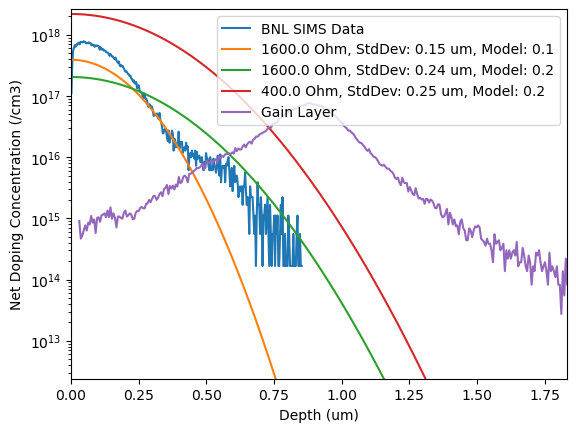

In [14]:
list_to_plot = []
for k in Data_Store.keys():
    if 400.0 in k:
        list_to_plot.append(k)
    elif 1600.0 in k:
        list_to_plot.append(k)
    elif 'BNL' in k:
        list_to_plot.append(k)
PlotSheetR(list_to_plot, savef_name='Doping_Profiles_FBK')

In [15]:
# BNL N+ Integral
n_dop_y, n_dop = read_dat(nPlus_layer_BNL)
print("BNL Trapz: {}".format(np.trapz(n_dop, n_dop_y)))

x, y = GaussData(0.0, 2.9053560382869197e+18, 0.05)
print("1600 Ohm/Sq: {}".format(np.trapz(y, x)))

x, y = GaussData(0.0, 4.025955653719365e+19, 0.02848536143921872)
print("400 Ohm/sq: {}".format(np.trapz(y,x)))


BNL Trapz: 1.3191344994738488e+17
1600 Ohm/Sq: 1.820661898359975e+17
400 Ohm/sq: 1.4373107034314028e+18
